In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import shap
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
import shap

In [2]:
# Import the one-hot encoded data.
data = pd.read_csv('full_data_ohe.csv')
# An error from writing with index.
data = data.drop(columns=['Unnamed: 0'])
# Reset retained index.
data = data.reset_index(drop=True)
# Set NA to 0.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)

In [3]:
# Sample 100000 for simplicity.
#data_sampled = data.sample(n=100000, random_state=42)
# Drop labels for scaling.
features = data.drop(columns=['attack_cat', 'label'])
label = data['label']
attack_cat = data['attack_cat']
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)
scaled_data_df = pd.DataFrame(scaled_data, columns=features.columns)
scaled_data_df['attack_cat'] = attack_cat.reset_index(drop=True)
# Split 20% test.
X_train, X_test, y_train, y_test = train_test_split(scaled_data_df, label, test_size=0.2, random_state=42)
# Drop attack cat before running model and store for later evaluation indexing.
test_attack_cat = X_test['attack_cat']
X_train = X_train.drop(columns=['attack_cat'])
X_test = X_test.drop(columns=['attack_cat'])
# Check label distribution.
print(scaled_data_df['attack_cat'].value_counts())


attack_cat
Normal            2218764
Generic            215481
Exploits            44525
Fuzzers             24246
DoS                 16353
Reconnaissance      13987
Analysis             2677
Backdoor             1795
Shellcode            1511
Backdoors             534
Worms                 174
Name: count, dtype: int64


In [4]:
# Run RandomForest with default settings.
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.99      0.99      0.99     64179

    accuracy                           1.00    508010
   macro avg       0.99      0.99      0.99    508010
weighted avg       1.00      1.00      1.00    508010

[[442983    848]
 [   925  63254]]


In [5]:
# Add labels back to the data and create a label list.
X_test['predicted_label'] = y_pred
X_test['true_label'] = y_test.values
X_test['attack_cat'] = test_attack_cat
X_test = X_test.reset_index(drop=True)
attack_categories = X_test['attack_cat'].unique()

In [6]:
# Iterate for each category label and group evaluation results and print.
for category in attack_categories:
    print(f"Evaluation for attack category: {category}")
    category_data = X_test[X_test['attack_cat'] == category]
    y_true_category = category_data['true_label']
    y_pred_category = category_data['predicted_label']
    correct_predictions = (y_true_category == y_pred_category).sum()
    total_samples = len(y_true_category)
    accuracy = accuracy_score(y_true_category, y_pred_category)
    precision = precision_score(y_true_category, y_pred_category, zero_division=0)
    recall = recall_score(y_true_category, y_pred_category, zero_division=0)
    f1 = f1_score(y_true_category, y_pred_category, zero_division=0)
    print(f"Total samples: {total_samples}")
    print(f"Correct predictions: {correct_predictions}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {f1}")
    print("\nClassification Report:\n", classification_report(y_true_category, y_pred_category, zero_division=0))
    print("-" * 50)

Evaluation for attack category: Normal
Total samples: 443831
Correct predictions: 442983
Accuracy: 0.9980893628430642
Precision: 0.0
Recall: 0.0
F1-Score: 0.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    443831
           1       0.00      0.00      0.00         0

    accuracy                           1.00    443831
   macro avg       0.50      0.50      0.50    443831
weighted avg       1.00      1.00      1.00    443831

--------------------------------------------------
Evaluation for attack category: Generic
Total samples: 43110
Correct predictions: 43102
Accuracy: 0.9998144282069126
Precision: 1.0
Recall: 0.9998144282069126
F1-Score: 0.9999072054934348

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      1.00      1.00     43110

    accuracy                           1.00     43110
   macr

In [8]:
X_test = X_test[X_test['attack_cat'] == 'DoS']
# Get correct only.
X_test['correct_predictions'] = X_test['predicted_label'] == X_test['true_label']
correct_predictions = X_test[X_test['correct_predictions'] == True]
data2 = correct_predictions.reset_index(drop=True).drop(columns=['correct_predictions', 'attack_cat', 'predicted_label', 'true_label'])
# Validate.
print("Correct Predictions (All):")
print(data2)
print(len(data2))

Correct Predictions (All):
           dur    sbytes    dbytes      sttl      dttl     sloss     dloss  \
0    -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
1    -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
2    -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
3    -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
4     0.003571 -0.060235 -0.216961 -0.010479  5.162862 -0.140512 -0.253194   
...        ...       ...       ...       ...       ...       ...       ...   
3304 -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
3305 -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
3306 -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
3307 -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   
3308 -0.047310 -0.073389 -0.226124  2.562463 -0.717997 -0.229334 -0.288533   

         sload     dload     spkts  

In [9]:
# Calculate shap.
# Correct Predictions = data2.
explainer = shap.TreeExplainer(rf)
shap_values2 = explainer.shap_values(data2)
# Verify shape.
print(shap_values2.shape)
print(data2.shape)

(3309, 111, 2)
(3309, 111)


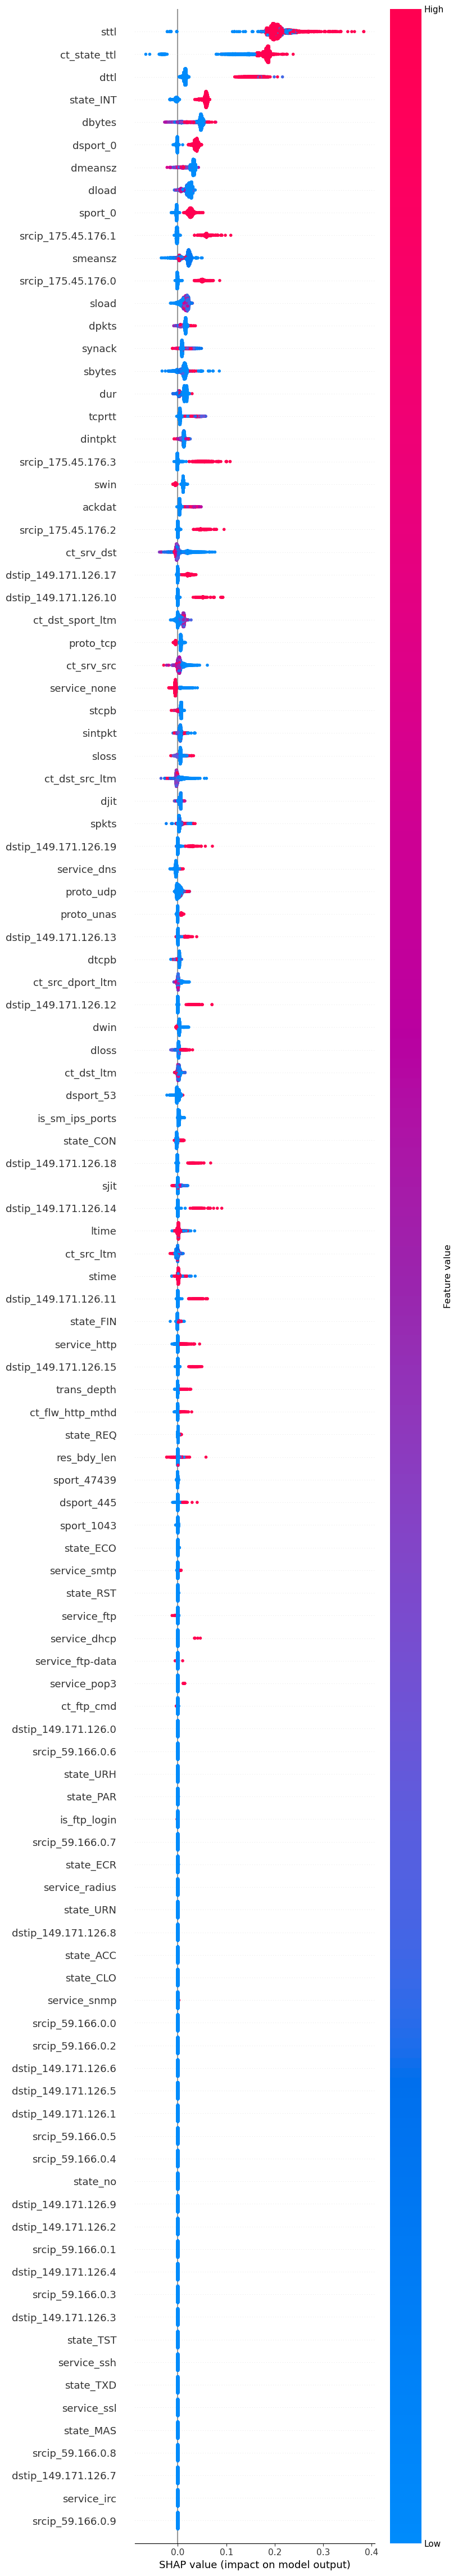

In [11]:
# Create summary plot of top all values.
shap.summary_plot(shap_values2[:, :, 1], data2, max_display=len(data2), show=True)